2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 2

System of ODE

Y'(x) = lambda * Y(x)

where Y(x) = [[y1(x)], [y2(x)]] & lambda = [[lamb1, 0], [0, lamb2]] and lamb1 != lamb2
                                  

Work 3

2차 add 2차 add 2차

Module import

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [55]:
# analysis 함수 
def anal(x, lamb):
    return np.exp(lamb*x)

# n : w 개수, w : weight
def y(x, w, n = 4):
    y = 1         # y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)
    for i in range(1, n+1):
        y += w[i-1]*(x**i)
    
    return y

def yprime(x, w, n = 4):
    yprime = 0    # yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3)
    for i in range(1, n + 1):
        yprime += i*w[i-1]*(x**(i-1))

    return yprime

def f(y, lamb):
    return lamb*y

def sigmoid(x):
    return 1 / (1 + tf.math.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(tf.experimental.numpy.dot(x, W[0]))
    return tf.experimental.numpy.dot(a1, W[1])

def d_neural_network_dx(W, x, k=1):
    return tf.experimental.numpy.dot(tf.experimental.numpy.dot(tf.transpose(W[1]), tf.transpose(W[0])**k), sigmoid_grad(x))

def net_out(W):
    return neural_network(W, 1)

def EC_predict(W, x, lamb, n):
    return f(net_out(W)*x**(n+1), lamb)

def d_net_out(W, x):
    return d_neural_network_dx(W, x)

# 수정
def EC_d_y(W, x, n):
    return (n+1)*(x**n)*net_out(W)

# System
def system_loss(y1, y2, lamb1, lamb2, y1_prime, y2_prime):
    loss = [y1_prime, y2_prime] - tf.experimental.numpy.dot([[lamb1, 0], [0, lamb2]], [y1, y2])
    return tf.norm(loss)

n : 차수

target_loss : loss_sum이 target_loss 보다 작아지면 early_stop 조건에 들어간다. 

early_stop : loss_sum 최소값 뒤로 최소값 갱신이 되지 않고, 정해진 값 이상 Epoch가 진행 되면 중단

learing_rate : 학습률

max_train_count : 최대 학습 횟수

In [56]:
def system_ODE_train(n = 2, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf, show_w_trace = True, show_loss_trace = True, show_error = True, show_compare_analysis = True,):
    x_max = 1
    x_slice = 100
    x = tf.Variable(np.array([[i/x_slice] for i in range(0, x_max * x_slice, 1)], dtype = np.float32))
    lamb1 = 1.0
    lamb2 = -1.0

    # 차수, weight 개수
    y1_w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # y1_w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    y2_w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # y2_w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 변화 w 값, loss 저장
    w_trace = []
    total_w = tf.concat([y1_w, y2_w], 0)
    w_trace.append(total_w.numpy())     # total_w = [y1_w1, y1_w2, ..., y1_wn, y2_w1, y2_w2, ..., y2_wn]
    loss_trace = []

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # y' = f(y, t)를 만족하는 y 찾는 과정
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    while True:
        Epoch += 1
        loss_sum = 0
        for x_unit in x:
            with tf.GradientTape() as tape:
                # 예측 값
                y1 = f(y(x_unit, y1_w, n), lamb1)
                y2 = f(y(x_unit, y2_w, n), lamb2)
                y1_prime = yprime(x_unit, y1_w, n)
                y2_prime = yprime(x_unit, y2_w, n)

                # [[y1'], [y2']] = [[f(y1, t)], [f(y2, t)]]
                loss = system_loss(y1, y2, lamb1, lamb2, y1_prime, y2_prime)
                loss_sum += float(loss)

            # Gradient 값 저장
            [y1_gradients, y2_gradients] = tape.gradient(loss, [y1_w, y2_w])
            # Gradient 값 w에 적용
            optimizer.apply_gradients(zip([y1_gradients, y2_gradients], [y1_w, y2_w]))
        
        # w 변화값 저장
        w_trace.append(total_w.numpy())

        # Epoch별 loss 합 저장
        loss_sum = float(loss_sum)
        loss_trace.append(loss_sum)
        
        # early stop
        low_loss = np.inf
        low_loss_Epoch = 0
        if target_loss >= loss_sum and loss_sum < low_loss:
            low_loss = loss_sum
            early_stop_w = total_w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch + early_stop <= Epoch:
            break
        
        if np.isnan(loss_sum):
            break

        if Epoch % 100 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, total_w.numpy()))

        if Epoch == max_train_count:
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}'.format(low_loss_Epoch, low_loss))
        
    print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, float(loss_sum)))

    if show_w_trace:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_title('Weight & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Weight')
        ax.plot(w_trace, label = ['y1_w{}'.format(i+1) for i in range(n)] + ['y2_w{}'.format(i+1) for i in range(n)])
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=10)
        ax.grid()

    if show_loss_trace:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_title('Loss & Epoch')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(loss_trace, label = 'loss')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_error:
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(abs(y(x, early_stop_w[0:n], n) - anal(x,lamb1)), label = 'y1 Error')
        ax.plot(abs(y(x, early_stop_w[n:], n) - anal(x,lamb2)), label = 'y2 Error')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    if show_compare_analysis:
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.set_title('Analysis & f(lambda*y) & Error')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.plot(anal(x,lamb1), label = 'y1 analysis')
        ax.plot(anal(x,lamb2), label = 'y2 analysis')
        ax.plot(y(x, early_stop_w[0:n], n), label = 'y1')
        ax.plot(y(x, early_stop_w[n:], n), label = 'y2')
        ax.tick_params(labelsize=10)
        ax.legend(fontsize=20)
        ax.grid()

    return early_stop_w

ODE + EC

Train

----------------------------------

In [57]:
system_w2_train = system_ODE_train(n = 2, max_train_count=500)

Epoch : 100, Loss_sum : 8.3030, w : [ 0.89039975  1.1713246   1.0990809  -0.7885705 ]


Epoch : 2, Loss_sum : 98.5153


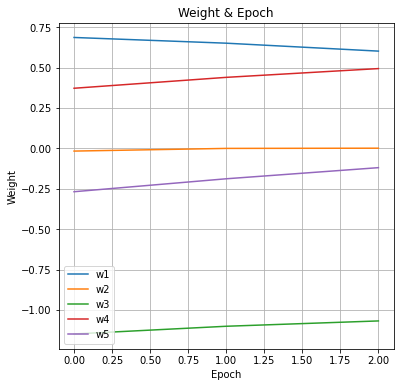

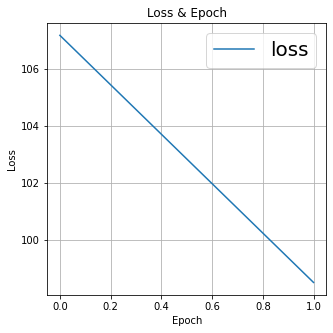

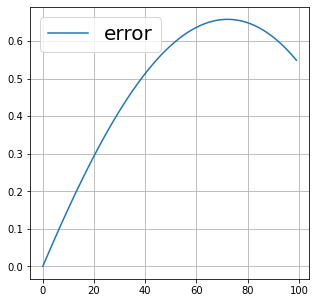

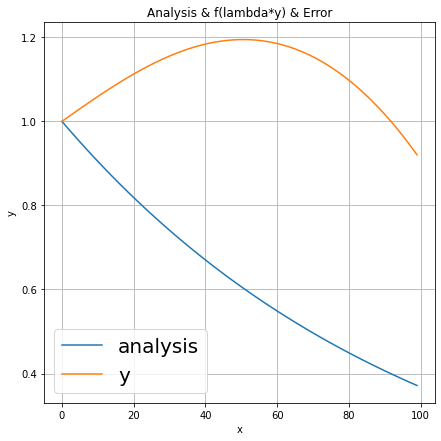

In [ ]:
system_w3_train = system_ODE_train(n = 3, max_train_count=500)

In [ ]:
# 2022.07.20
# 에러 그래프 부분 보강
# epoch 늘려서 학습 결과 찾기
# w 값 
# w1 = lambda와 비슷하게 -2
# w2 = 2
# w3 = -1
# w4 = 0.5
# layer 구조 확인

# 2022.08.03
# 모델 부분 input -> layer -> layer -> output
# layer 추가 할 수 있게 만들어 놓기

# 2022.08.23
# x 범위 증가 대신 개수 증가로 0 ~ 1 사이
# 코드 공유
# Error 파트 layer 추가
# Solution + Error
##  추가 학습 필요 내용 ## 
# Error에 따른 weight 업데이트 과정 수식 확인
# 비지도 학습 진행과정
